In [2]:
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [5]:
import os

In [11]:
DIRNAME = os.path.dirname(os.getcwd())
IMG_PATH = os.path.join(DIRNAME,"data")
IMG_ANNOTATION_PATH = os.path.join(DIRNAME,"data_annotation.csv")

In [99]:
dataset = pd.read_csv(IMG_ANNOTATION_PATH,sep=";")

In [100]:
dataset = dataset.rename(columns={'Nom image': 'image_label', 'Nombre de pièces': 'nb_coins', 'Valeur ': 'value'})

In [102]:
split_values = dataset['value'].str.split().tolist()
values_dict_list = []
for value in split_values:
    if len(value) > 2 :
        values_dict_list.append({"units":value[0],"cents":value[2]})
    elif len(value) == 2 :
        if "euro" in value[1]:
            values_dict_list.append({"units":value[0],"cents":0})
        elif "cent" in value[1]:
            values_dict_list.append({"units":0,"cents":value[0]})



In [103]:
values_df = pd.DataFrame(values_dict_list)
values_df

,units,cents
0,3,32
1,3,32
2,1,66
3,1,66
4,1,19
...,...,...
77,1,0
78,3,20
79,4,80
80,0,35


In [104]:
dataset = pd.concat([dataset, values_df], axis=1)

In [107]:
dataset.to_csv("data_clean.csv", index=False)

In [108]:
def read_images():
    images = {}
    for filename in os.listdir(IMG_PATH):
        img = cv2.imread(os.path.join(IMG_PATH, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images[filename] = img
        else:
            print("Error with file", filename)
    return images

In [109]:
images = read_images()


In [117]:
img = images["2e01c.jpg"]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [111]:
annotation = dataset[dataset["image_label"] == "2e01c.jpg"]

In [112]:
annotation

,image_label,nb_coins,value,units,cents
19,2e01c.jpg,2,2 euros 1 centimes,2,1


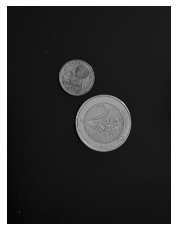

In [118]:
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [122]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [128]:
blurred = cv2.GaussianBlur(img, (9, 9), 2)

# Detect circles using Hough Circle Transform
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=200, param2=20, minRadius=30, maxRadius=0)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]
        # Draw the circle
        cv2.circle(img, center, radius, (0, 255, 0), 2)

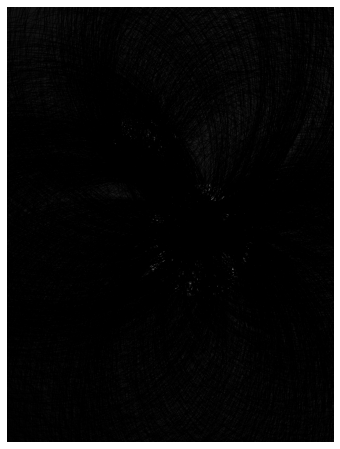

In [129]:
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()